In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf_file
import networkx as nx

In [4]:
#dataset = 'data10102019'
dataset = "01052014"
f = netcdf_file(f'{dataset}.nc', mmap=False)
# f = netcdf_file('04032019.nc',mmap=False)

#### Extract the variables from the data

In [5]:
lon = f.variables['longitude'].data.copy()
lat = f.variables['latitude'].data.copy()
times = f.variables['time'].data.copy()

raw_vel_x = f.variables['ugos'].data.copy().squeeze()
raw_vel_y = f.variables['vgos'].data.copy().squeeze()

In [6]:
print("Lon shape",lon.shape)
print("Lat shape",lat.shape)
print("vel_x shape",raw_vel_x.shape)
print("vel_y shape",raw_vel_y.shape)

Lon shape (81,)
Lat shape (320,)
vel_x shape (320, 81)
vel_y shape (320, 81)


#### Fix missing data

In [7]:
from common_functions import interpolate_missing_point

vel_x = np.ma.masked_where(np.isnan(raw_vel_x),raw_vel_x)
vel_y = np.ma.masked_where(np.isnan(raw_vel_y),raw_vel_y)

#### Now to begin the algorithm

#### Step 1: Compute the normal vector at each point in the grid

Note: the normal vectors could be either positive or negative. Depending on the rotation of the eddy, I think the vectors will either point all out or all in. So possibly need to do twice, taking negative normal second time.
$$
\text{If}
\\
\mathbf{v} = (x,y)
\\
\text{then either}
\\
\mathbf{n} = (-y,x) = \mathbf{n_1}
\\
\text{or}
\\
\mathbf{n} = -\mathbf{n_1} = (y,-x) = \mathbf{n_2}

In [8]:
vel_norm1_x = - vel_y
vel_norm1_y = vel_x

#Opposite normal
vel_norm2_x = vel_y
vel_norm2_y = - vel_x

Calculate angle theta as
$$ \theta = \arctan(\frac{y}{x})

In [9]:
theta1 = np.arctan2(vel_norm1_y,vel_norm1_x)
theta2 = np.arctan2(vel_norm2_y,vel_norm2_x)

Consider whether small magnitude vectors should 

In [11]:
def calc_grid_direction(theta,i,j):
    #theta is angle in radians of the direction of the vector. Measured anticlockwise from the horizontal
    #i,j are the x,y indeces of the cell of the vector
    #returns output of the cell the vector is pointing to

    #Initialise output indices as same as current cell
    i_out = i
    j_out = j

    #Determine which region angle falls in
    if -np.pi/8 < theta <= np.pi/8:
        cell = 1
        j_out += 1
    elif np.pi/8 < theta <= 3*np.pi/8:
        cell = 2
        j_out += 1
        i_out += 1
    elif 3*np.pi/8 < theta <= 5*np.pi/8:
        cell = 3
        i_out += 1
    elif 5*np.pi/8 < theta <= 7*np.pi/8:
        cell = 4
        j_out -= 1
        i_out += 1
    elif 7*np.pi/8 < theta <= np.pi or -np.pi <= theta <= -7*np.pi/8:
        cell = 5
        j_out -= 1
    elif -7*np.pi/8 < theta <= -5*np.pi/8:
        cell = 6
        j_out -= 1
        i_out -= 1
    elif -5*np.pi/8 < theta <= -3*np.pi/8:
        cell = 7
        i_out -= 1
    elif -3*np.pi/8 < theta <= -np.pi/8:
        cell = 8
        j_out += 1
        i_out -= 1
    else:
        print("Error: not in within any sectors")
        cell=np.nan

    return cell,i_out,j_out

In [12]:
directions1 = np.zeros(theta1.shape)
for i in range(0,theta1.shape[0]):
    for j in range(0,theta1.shape[1]):
        try:
            cell,i_out,j_out= calc_grid_direction(theta1[i,j],i,j)
            directions1[i,j] = cell
        except:
            continue

directions2 = np.zeros(theta2.shape)
for i in range(0,theta2.shape[0]):
    for j in range(0,theta2.shape[1]):
        try:
            cell,i_out,j_out= calc_grid_direction(theta2[i,j],i,j)
            directions2[i,j] = cell
        except:
            continue

directions1 = np.ma.masked_where(directions1==0,directions1)
directions2 = np.ma.masked_where(directions2==0,directions2)

Error: not in within any sectors
Error: not in within any sectors


In [13]:
class grid_cell:
    def __init__(self):
        self.num_pointed_from = 0
        self.indices_pointed_from = np.array([[]])
        self.neighbours = np.array([])
    def set_num_pointed_from(self,new_val):
        self.num_pointed_from = new_val
    def add_new_pointed_from(self,new_coord):
        self.indices_pointed_from = np.array(np.vstack([self.indices_pointed_from,new_coord]) if self.indices_pointed_from.size else new_coord)
    def add_new_grid_neighbour(self,new_neighbour):
        self.neighbours = np.array( np.vstack([self.neighbours,new_neighbour]) if self.neighbours.size else new_neighbour)

Make an adjacency matrix for graph later

In [14]:
#Setup array of grid_cell objects
grid_neighbours1 = np.array( [ [ grid_cell() for i in range(0,theta1.shape[1]) ] for j in range(0,theta1.shape[0]) ],dtype=object)
#Adjacency matrix for which node points to which node
grid_flat_size1 = grid_neighbours1.size
adjacency1 = np.zeros((grid_flat_size1,grid_flat_size1))

for i in range(0,theta1.shape[0]):
    for j in range(0,theta1.shape[1]):
        
        direction_pointing, target_i,target_j = calc_grid_direction(theta1[i,j],i,j)

        #Check if neighbour if within the grid
        if 0 <= target_i <= theta1.shape[0]-1 and 0 <= target_j <= theta1.shape[1]-1:
            start_node_flat_index = np.ravel_multi_index([i,j],grid_neighbours1.shape)
            end_node_flat_index = np.ravel_multi_index([target_i,target_j],grid_neighbours1.shape)
            adjacency1[start_node_flat_index,end_node_flat_index] = 1

            grid_neighbours1[target_i,target_j].add_new_pointed_from(np.array([i,j]))
            grid_neighbours1[target_i,target_j].num_pointed_from += 1
            grid_neighbours1[target_i,target_j].add_new_grid_neighbour([direction_pointing])

#Second normal
#Setup array of grid_cell objects
grid_neighbours2 = np.array( [ [ grid_cell() for i in range(0,theta2.shape[1]) ] for j in range(0,theta2.shape[0]) ],dtype=object)
#Adjacency matrix for which node points to which node
grid_flat_size2 = grid_neighbours2.size
adjacency2 = np.zeros((grid_flat_size2,grid_flat_size2))

for i in range(0,theta2.shape[0]):
    for j in range(0,theta2.shape[1]):

        direction_pointing, target_i,target_j = calc_grid_direction(theta2[i,j],i,j)

        #Check if neighbour if within the grid
        if 0 <= target_i <= theta2.shape[0]-1 and 0 <= target_j <= theta2.shape[1]-1:
            start_node_flat_index = np.ravel_multi_index([i,j],grid_neighbours2.shape)
            end_node_flat_index = np.ravel_multi_index([target_i,target_j],grid_neighbours2.shape)
            adjacency2[start_node_flat_index,end_node_flat_index] = 1

            grid_neighbours2[target_i,target_j].add_new_pointed_from(np.array([i,j]))
            grid_neighbours2[target_i,target_j].num_pointed_from += 1
            grid_neighbours2[target_i,target_j].add_new_grid_neighbour([direction_pointing])


Error: not in within any sectors
Error: not in within any sectors


In [15]:
grid_flattened1 = grid_neighbours1.flatten()
grid_size1 = grid_flattened1.size

grid_flattened2 = grid_neighbours2.flatten()
grid_size2 = grid_flattened2.size

In [16]:
#Make lists of edges
indices_list1 = list(np.zeros(grid_size1))
for index in range(0,grid_size1):
    grid_index = np.unravel_index(index,grid_neighbours1.shape)
    indices_list1[index] = grid_neighbours1[grid_index[0],grid_index[1]].indices_pointed_from
# indices_list

#Make lists of edges
indices_list2 = list(np.zeros(grid_size2))
for index in range(0,grid_size1):
    grid_index = np.unravel_index(index,grid_neighbours2.shape)
    indices_list2[index] = grid_neighbours2[grid_index[0],grid_index[1]].indices_pointed_from
# indices_list

In [17]:
G1 = nx.from_numpy_matrix(adjacency1,create_using=nx.DiGraph)

G2 = nx.from_numpy_matrix(adjacency2,create_using=nx.DiGraph)

Check if any cells have a high enough neighbours to constitute an eddy

In [18]:
def vec_normal(max_no_cells_pointed, min_neighbours_for_eddy):
    max_no_cells_pointed1 = max_no_cells_pointed
    potential_eddy_coords1 = np.array([[]])
    min_neighbours_for_eddy1 = min_neighbours_for_eddy

    for i in range(0,theta1.shape[0]):
        for j in range(0,theta1.shape[1]):
            if grid_neighbours1[i,j].num_pointed_from >= min_neighbours_for_eddy1:
                potential_eddy_coords1 = np.array(np.vstack([potential_eddy_coords1,[[i,j]]]) if potential_eddy_coords1.size else [[i,j]])

            if grid_neighbours1[i,j].num_pointed_from > max_no_cells_pointed1:
                max_no_cells_pointed1 = grid_neighbours1[i,j].num_pointed_from
                max_coords = [i,j]

    max_no_cells_pointed2 = max_no_cells_pointed
    potential_eddy_coords2 = np.array([[]])
    min_neighbours_for_eddy2 = min_neighbours_for_eddy

    for i in range(0,theta2.shape[0]):
        for j in range(0,theta2.shape[1]):
            if grid_neighbours2[i,j].num_pointed_from >= min_neighbours_for_eddy2:
                potential_eddy_coords2 = np.array(np.vstack([potential_eddy_coords2,[[i,j]]]) if potential_eddy_coords2.size else [[i,j]])

            if grid_neighbours2[i,j].num_pointed_from > max_no_cells_pointed1:
                max_no_cells_pointed2 = grid_neighbours2[i,j].num_pointed_from
                max_coords = [i,j]


    symmetrical_coords1 = np.array([[]])

    for coord in potential_eddy_coords1:
        neighbour_directions1 = grid_neighbours1[coord[0],coord[1]].neighbours

        #Check if at least one neighbour in each of the four quadrants, split as region A:[1,2], B:[3,4], C:[5,6] ,D:[7,8]
        in_a = False
        in_b = False
        in_c = False
        in_d = False

        for neighbour in neighbour_directions1:
            if np.any((neighbour==1)|(neighbour==2)):
                in_a=True
            elif np.any((neighbour==3)|(neighbour==4)):
                in_b=True
            elif np.any((neighbour==5)|(neighbour==6)):
                in_c=True
            elif np.any((neighbour==7)|(neighbour==8)):
                in_d=True

        if all((in_a,in_b,in_c,in_d)):
            symmetrical_coords1 = np.array(np.vstack([symmetrical_coords1,coord]) if symmetrical_coords1.size else coord)


    symmetrical_coords2 = np.array([[]])

    for coord in potential_eddy_coords2:
        neighbour_directions2 = grid_neighbours2[coord[0],coord[1]].neighbours

        #Check if at least one neighbour in each of the four quadrants, split as region A:[1,2], B:[3,4], C:[5,6] ,D:[7,8]
        in_a = False
        in_b = False
        in_c = False
        in_d = False

        for neighbour in neighbour_directions2:
            if np.any((neighbour==1)|(neighbour==2)):
                in_a=True
            elif np.any((neighbour==3)|(neighbour==4)):
                in_b=True
            elif np.any((neighbour==5)|(neighbour==6)):
                in_c=True
            elif np.any((neighbour==7)|(neighbour==8)):
                in_d=True

        if all((in_a,in_b,in_c,in_d)):
            symmetrical_coords2 = np.array(np.vstack([symmetrical_coords2,coord]) if symmetrical_coords2.size else coord)

    #Find all the connected nodes for each cell
    node_list1 = np.array(G1.nodes)
    connected_nodes1 = list(np.zeros(node_list1.size))
    for i in range(0,node_list1.size):
        connected_nodes1[i] = np.array(nx.bfs_tree(G1,i,reverse=False).nodes)


    #Find all the connected nodes for each cell
    node_list2 = np.array(G2.nodes)
    connected_nodes2 = list(np.zeros(node_list2.size))
    for i in range(0,node_list2.size):
        connected_nodes2[i] = np.array(nx.bfs_tree(G2,i,reverse=False).nodes)

    eddie_coords1 = np.array([[]])
    tol1 = 3

    for i in range(0,symmetrical_coords1.shape[0]):
        connected = connected_nodes1[i]
        no_connected = connected.size
        child_depths = []
        for j in range(0,connected.size):
            child_depths.append(connected_nodes1[j].size)
        child_depths = np.array(child_depths)
        vals,counts = np.unique(child_depths,return_counts=True)
        mode_child_depth = np.mean(vals[np.argwhere(counts==np.max(counts))])
        # print(no_connected,"   ",np.floor(np.pi * mode_child_depth**2 - tol1))
        if no_connected > np.floor(np.pi * mode_child_depth**2 - tol1):
            eddie_coords1 = np.array(np.vstack([eddie_coords1,symmetrical_coords1[i]]) if eddie_coords1.size else symmetrical_coords1[i])


    #Normal 2
    eddie_coords2 = np.array([[]])
    tol2 = 3

    for i in range(0,symmetrical_coords2.shape[0]):
        connected = connected_nodes2[i]
        no_connected = connected.size
        child_depths = []
        for j in range(0,connected.size):
            child_depths.append(connected_nodes2[j].size)
        child_depths = np.array(child_depths)
        vals,counts = np.unique(child_depths,return_counts=True)
        mode_child_depth = np.mean(vals[np.argwhere(counts==np.max(counts))])
        # print(no_connected,"   ",np.floor(np.pi * mode_child_depth**2 - tol1))
        if no_connected > np.floor(np.pi * mode_child_depth**2 - tol2):
            eddie_coords2 = np.array(np.vstack([eddie_coords2,symmetrical_coords2[i]]) if eddie_coords2.size else symmetrical_coords2[i])

    #Combine the two arrays
    all_eddies = np.vstack((eddie_coords1,eddie_coords2))
    return np.column_stack([lat[all_eddies[:,0]], lon[all_eddies[:,1]]])

In [19]:
from dataclasses import dataclass

from scipy.spatial import KDTree
from sklearn.metrics.pairwise import haversine_distances
import pandas as pd

real_data = pd.read_csv("validation_data/01052014.csv")
real_data = real_data[["Lat","Lon"]].to_numpy()
real_data = real_data[(real_data[:,1] > -30) & (real_data[:,1] < -20) & (real_data[:,0] > 20) & (real_data[:,0] < 60)]

@dataclass
class Method:
    name: str
    points: np.ndarray
    P: int = 0
    TP: int = 0
    FP: int = 0
        
    def compare(self, ground_truth: np.ndarray, dist_tol):
        '''dist_tol is in km'''
        self.P = ground_truth.shape[0]
        
        tree_detected = KDTree(self.points)
        dist, index = tree_detected.query(ground_truth[:,0:2])
        truth = np.deg2rad(ground_truth[:,0:2])
        detected = np.deg2rad(self.points[index,:])
        dist_mat = haversine_distances(truth, detected)
        dist = np.diagonal(dist_mat) * 6371000/1000  # multiply by Earth radius to get kilometers
        
        self.TP = (dist < dist_tol).sum()
        self.mean_error = np.mean(dist[dist < dist_tol])
        self.FN = self.P - self.TP
        
        tree_truth = KDTree(ground_truth[:,0:2])
        dist, index = tree_truth.query(self.points)
        detected = np.deg2rad(ground_truth[index,0:2])
        dist_mat = haversine_distances(truth, detected)
        dist = np.diagonal(dist_mat) * 6371000/1000  # multiply by Earth radius to get kilometers
                
        self.FP = (dist > dist_tol).sum()
    
    @property
    def TPR(self):
        return self.TP/self.P
    
    @property
    def FDR(self):
        return self.FP/(self.FP + self.TP)
    
    @property
    def F1(self):
        return self.TP/(self.TP + 0.5*(self.FP + self.FN))

In [21]:
res = np.empty((10,10))
for a in range(10):
    for b in range(10):
        try:
            method = Method("",vec_normal(a+1,b+1))
            method.compare(real_data, 50)
            res[a,b] = method.F1
        except IndexError:
            res[a,b] = 0

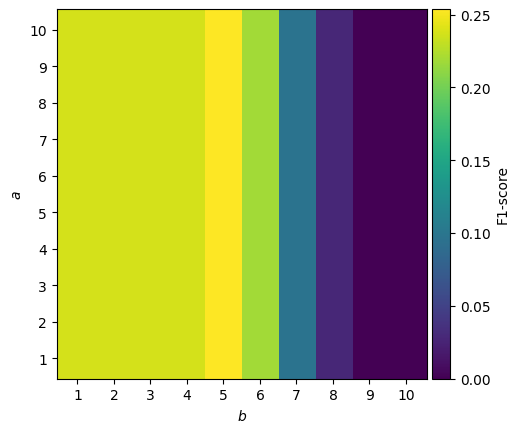

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure()
im=plt.imshow(res, origin='lower', extent=[1,10,1,10], aspect='equal')
plt.ylabel("$a$")
plt.xlabel("$b$")
plt.xticks(np.linspace(1.5,9.5,10))
plt.yticks(np.linspace(1.5,9.5,10))
ax = plt.gca()
ax.set_xticklabels(range(1,11))
ax.set_yticklabels(range(1,11))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
   
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("F1-score")

In [24]:
print(res)

[[0.23741007 0.23741007 0.23741007 0.23741007 0.25373134 0.21818182
  0.0969697  0.02816901 0.         0.        ]
 [0.23741007 0.23741007 0.23741007 0.23741007 0.25373134 0.21818182
  0.0969697  0.02816901 0.         0.        ]
 [0.23741007 0.23741007 0.23741007 0.23741007 0.25373134 0.21818182
  0.0969697  0.02816901 0.         0.        ]
 [0.23741007 0.23741007 0.23741007 0.23741007 0.25373134 0.21818182
  0.0969697  0.02816901 0.         0.        ]
 [0.23741007 0.23741007 0.23741007 0.23741007 0.25373134 0.21818182
  0.0969697  0.02816901 0.         0.        ]
 [0.23741007 0.23741007 0.23741007 0.23741007 0.25373134 0.21818182
  0.0969697  0.02816901 0.         0.        ]
 [0.23741007 0.23741007 0.23741007 0.23741007 0.25373134 0.21818182
  0.0969697  0.02816901 0.         0.        ]
 [0.23741007 0.23741007 0.23741007 0.23741007 0.25373134 0.21818182
  0.0969697  0.02816901 0.         0.        ]
 [0.23741007 0.23741007 0.23741007 0.23741007 0.25373134 0.21818182
  0.0969697 